# Business Analysis Project Using SQL

We'll be working with a modified version of a database called [Chinook](https://github.com/lerocha/chinook-database). The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.  

Here's a schema diagram for the Chinook database.

![Chinook schema diagram](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)


In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


## Overview of database schema

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# Selecting New Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we have been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name| Genre |
| --- | --- | 
| Regal | Hip-Hop |
| Red Tone | Punk | 
| Meteor and the Girls | Pop | 
| Slim Jim Bites | Blues | 

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

- Subquery - to get all the USA based customers with invoice details
- Main query - to compute percentage of tracks_sold in each genre 



In [4]:

%%sql
WITH usa_tracks_sold AS 
    (SELECT * 
     FROM customer c
     INNER JOIN invoice i ON i.customer_id=c.customer_id
     INNER JOIN invoice_line il ON i.invoice_id=il.invoice_id WHERE c.country="USA")

SELECT
    g.name genre_name,
    SUM(uts.quantity) tracks_sold,
    ROUND (CAST(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) From usa_tracks_sold), 2) AS percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON uts.track_id=t.track_id 
INNER JOIN genre g ON g.genre_id=t.genre_id GROUP BY 1 ORDER BY 2 DESC;       



 * sqlite:///chinook.db
Done.


genre_name,tracks_sold,percentage_sold
Rock,561,0.53
Alternative & Punk,130,0.12
Metal,124,0.12
R&B/Soul,53,0.05
Blues,36,0.03
Alternative,35,0.03
Latin,22,0.02
Pop,22,0.02
Hip Hop/Rap,20,0.02
Jazz,14,0.01


**REMARK:** 
The _most popular genres in the USA_ are **Rock**, **Alternative & Punk**, and **Metal**, followed with a big gap by all the others. Since our choice is limited by Hip-Hop, Punk, Pop, and Blues genres, and since we have to choose 3 out of 4 albums, we can say that only one of the albums to be advertised is related to these popular genres (**Punk**). Then, we should select the album of **Blues** genre (on the 5th place by popularity) and the one of **Pop** (on the 7th place):

| Artist Name          | Genre   |
| -------------------- | ------- |
| Red Tone             | Punk    |
| Slim Jim Bites       | Blues   |
| Meteor and the Girls | Pop     |

As we examine the popularity of genre based on records sold, Punk, Blue, and Pop are the genres that should be added to the record label.

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing the employee performance 

Each customer in the Chinook store, when they first make a purchase, gets assigned to a sales support agent within the company. We're going to analyze the purchases of customers belonging to each sales support agent, in order to compare their sales performance.

Let's find the total dollar amounts of sales assigned to each sales support agent, together with their country, birthdate, hire date, and number and % of customers. The tables to be used here are `employee`, `customer`, and `invoice`. Again, we'll represent this information also in graphical form, using a grouped bar chart. Since we're going to use this kind of charts further in the project, we'll create a function for it.

In [5]:
%%sql

WITH employee_sales AS 
    (SELECT e.employee_id, 
            e.first_name|| " "||e.last_name employee_name,
            e.hire_date,
            c.customer_id, i.invoice_id,i.total 
    FROM employee e 
    INNER JOIN customer c ON e.employee_id=c.support_rep_id 
    INNER JOIN invoice i ON c.customer_id=i.customer_id)
    
SELECT es.employee_name,
       es.hire_date,
       SUM(es.total) total_sales,
       ROUND((CAST(SUM(es.total) AS FLOAT)/(SELECT SUM(total) FROM employee_sales))*100,2) percentage_sales
FROM employee_sales es GROUP BY 1 ORDER BY 3 DESC;

 * sqlite:///chinook.db
Done.


employee_name,hire_date,total_sales,percentage_sales
Jane Peacock,2017-04-01 00:00:00,1731.5100000000039,36.77
Margaret Park,2017-05-03 00:00:00,1584.0000000000034,33.63
Steve Johnson,2017-10-17 00:00:00,1393.920000000002,29.6


There are 3 sales support agents among the employees, they are all from Canada and were employed in 2017 (April, May and October). The youngest of them is Jane Peacock, the oldest - Margaret Park.

On one hand, we see a direct correlation between the hire date of a sales support agent and the total amount of sales. However, we also see that the first 2 employees have only 1 month difference in their hire date; moreover, Margaret Park, being hired later, had 2 more customers. Despite that, they have 3% difference in their total amounts of sales, whereas Steve Johnson, being hired more than 6 months after Jane Peacock, has only 7% less sales than him, and 4% less customers.

Given that, Jane Peacock demonstrates the best sales performance, while Margaret Park - the worst.

## Analyzing Sales by Country

There are a number of countries with only one customer, we will group these customers as "other" in our analysis. 

Let's now compare data on purchases for customers from different countries, including total number and % of customers, total value and % of sales, average value of sales per customer, average order value. Because in our database there are some countries with only one customer, we'll collect those countries into an "Other" group. The results will be sorted by the total sales in descending order, with the "Other" group at the bottom of the table, and then displayed as a grouped bar chart. All the data necessary for this analysis is contained in the tables customer and invoice.

In [6]:
%%sql
WITH country_or_other AS
     (SELECT 
            CASE
                WHEN (SELECT COUNT(*) FROM customer WHERE country=c.country)=1 THEN "other"
                ELSE country
            END country,
            customer_id
     FROM customer c)
    
SELECT  c.country,
        COUNT(distinct c.customer_id) total_customers,
        ROUND(SUM(i.total),1) total_sales, 
        ROUND(CAST(SUM(i.total) AS FLOAT)/COUNT(c.customer_id),2) avg_sales_per_customer, 
        ROUND(CAST(SUM(i.total) AS FLOAT)/COUNT(i.invoice_id),2) avg_order_value,
        CASE
            WHEN country = "other" THEN 1
            ELSE 0
        END AS sort
FROM country_or_other c 
LEFT JOIN invoice i ON c.customer_id=i.customer_id 
GROUP BY 1 
ORDER BY sort ASC, 4 DESC;

 * sqlite:///chinook.db
Done.


country,total_customers,total_sales,avg_sales_per_customer,avg_order_value,sort
Czech Republic,2,273.2,9.11,9.11,0
United Kingdom,3,245.5,8.77,8.77,0
India,2,183.2,8.72,8.72,0
Germany,4,334.6,8.16,8.16,0
USA,13,1040.5,7.94,7.94,0
France,5,389.1,7.78,7.78,0
Canada,8,535.6,7.05,7.05,0
Brazil,5,427.7,7.01,7.01,0
Portugal,2,185.1,6.38,6.38,0
other,15,1094.9,7.45,7.45,1


**REMARK**  Based on our analysis, Czech Republic, UK and India are top 3 countries with highest average sales per customer. There is a potential to tap the market in these countries.

## Analyzing percentage of purchases of individual tracks vs whole albums

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

- **Question:** So, we find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

- For performing an analysis we have 'edge cases' which prevent us from getting a 100% accurate answer to our question. In this instance, we have two edge cases to consider:

    - Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
    - Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.
    
Since our analysis is concerned with maximizing revenue we can safely ignore edge cases. 

**Solution: We start by analyzing by identifying whether each invoice has all the tracks from an album.**
- Comparing list of tracks from invoice with list of tracks from an album
    - Find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.
    - NOTE: Album has list of tracks, invoice has list of invoice_line_ids, and invoice_line_id has list of tracks

In [7]:
%%sql
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674



Album purchases account for 18.6% of purchases. 

This means that the new strategy in consideration (purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums) will definitely help to maximize the overall revenue.

## Which artist is used in the most playlists?

In [8]:
%%sql

WITH artist_track AS 
                (SELECT a.name,t.track_id FROM artist a 
                 LEFT JOIN album al ON a.artist_id=al.artist_id 
                 LEFT JOIN track t ON t.album_id=al.album_id ORDER BY 1),
     playlist_name_track AS 
                      (SELECT p.name playlist_name, pt.track_id 
                      FROM playlist_track pt 
                      LEFT JOIN playlist p 
                      ON p.playlist_id=pt.playlist_id 
                      ORDER BY 1) 
    
SELECT at.name, 
       COUNT(pnt.playlist_name) AS in_no_of_playlists,
       ROUND(CAST(COUNT(pnt.playlist_name) AS FLOAT)/ (SELECT COUNT(*) FROM playlist),2) percentage FROM artist_track at 
LEFT JOIN playlist_name_track pnt ON at.track_id=pnt.track_id GROUP BY 1 ORDER BY 2 DESC LIMIT 10;

 * sqlite:///chinook.db
Done.


name,in_no_of_playlists,percentage
Iron Maiden,516,28.67
U2,333,18.5
Metallica,296,16.44
Led Zeppelin,252,14.0
Deep Purple,226,12.56
Lost,184,10.22
Pearl Jam,177,9.83
Eric Clapton,145,8.06
Faith No More,145,8.06
Lenny Kravitz,143,7.94


**REMARK:** Iron Maiden, U2, Metallica, Led Zeppelin and Deep Purple who are listed among top 5 popular artists.

## How many tracks have been purchased vs not purchased?

In [9]:
%%sql
WITH album_track AS
    (
     SELECT
         a.album_id album_id,
         t.track_id track_id
     FROM album a 
     LEFT JOIN track t ON t.album_id=a.album_id
    )

SELECT
    COUNT(DISTINCT(il.track_id)) tracks_purchased,
    (COUNT(DISTINCT(at.track_id)) - COUNT(DISTINCT(il.track_id))) tracks_not_purchased
FROM album_track at 
LEFT JOIN invoice_line il ON at.track_id=il.track_id;

 * sqlite:///chinook.db
Done.


tracks_purchased,tracks_not_purchased
1806,1697


Almost half of all the unique tracks available in the Chinook store were never bought, probably being of unpopular genre or unpopular artists. Possible solutions here may include a new _advertising campaign_ (especialy in the USA, as the biggest segment of market), _sales promotion_, additional _training and motivation_ of the sales support agents.

## Is the range of tracks in the store reflective of their sales popularity?

In [10]:
%%sql
SELECT (SELECT COUNT(track_id) FROM track) range_of_tracks,
       COUNT(DISTINCT(track_id)) distinct_tracks_sold, 
       COUNT(*) total_tracks_sold,
       ROUND(CAST(COUNT(DISTINCT(track_id)) AS FLOAT) /(SELECT COUNT(track_id) FROM track),2)*100 "distinct_percentage_of_tracks_sold(%)"
FROM invoice_line;

 * sqlite:///chinook.db
Done.


range_of_tracks,distinct_tracks_sold,total_tracks_sold,distinct_percentage_of_tracks_sold(%)
3503,1806,4757,52.0


Over 50% of the tracks sold from the available tracks. Since, total tracks sold is almost 3 times more than the distinct tracks sold infers that some of the tracks are very popular and we sold more than 1 time.

## Do protected vs non-protected media types have an effect on popularity?

If a track has a protected media type, it means that it has some associated rules for using its content. It can be encrypted using some form of digital rights management encryption. To play such a file, playback must occur inside the protected media path. In addition, the user might have to acquire rights to the content.

Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [11]:
%%sql
SELECT mt.name, 
       COUNT(mt.media_type_id) total_sales
FROM media_type mt
INNER JOIN track t ON mt.media_type_id=t.media_type_id
INNER JOIN invoice_line il ON t.track_id=il.track_id
GROUP BY 1 
ORDER BY 2 DESC;
       

 * sqlite:///chinook.db
Done.


name,total_sales
MPEG audio file,4259
Protected AAC audio file,439
Purchased AAC audio file,35
AAC audio file,21
Protected MPEG-4 video file,3


**REMARK** Two of the five media types are protected.

Protected media type is less popular when compared to unprotected media. It could be because copyright restriction. 



               unique_tracks  pct_unique  sold_unique  pct_sold_unique
media_type                                                            
Non-protected           3052        87.0         1652             54.0
Protected                451        13.0          154             34.0


               sold  pct_sold
media_type                   
Non-protected  4315      91.0
Protected       442       9.0




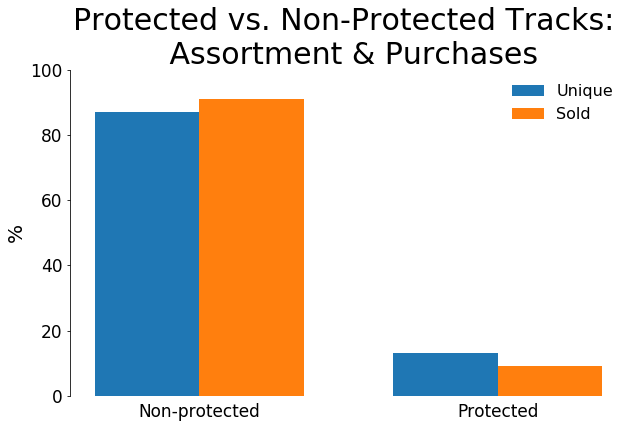

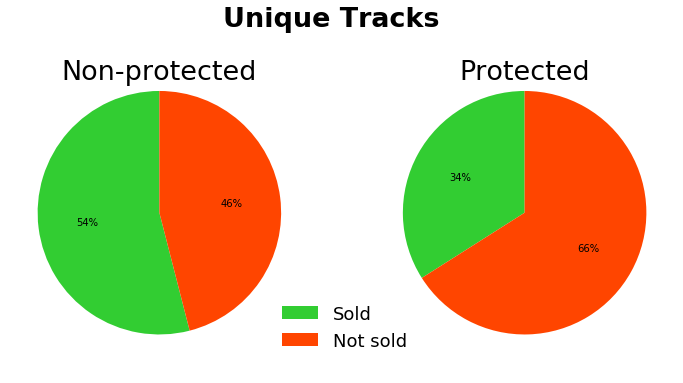

In [13]:
# Defining a function for creating grouped bar charts
def plot_grouped_bar_chart(fig_width, fig_height, 
                           column1, column2, 
                           label1, label2, 
                           title, ylabel, 
                           ylim_lower, ylim_upper, 
                           loc, rotation, bbox_to_anchor):
    
    # Converting series to lists
    column1_list = column1.to_list()   
    column2_list = column2.to_list()
        
    # Creating labels from the index
    labels = df.index.to_list()
    
    # Specifying the label locations and the width of the bars
    x = np.arange(len(labels)) 
    width = 0.35
    
    # Plotting the data
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2,
           column1_list,
           width, 
           label=label1)
    ax.bar(x + width/2,
           column2_list, 
           width,
           label=label2)
    ax.set_title(title, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, 
                       fontsize=17, 
                       rotation=rotation)
    ax.tick_params(bottom = False, 
                   labelsize=17)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.legend(loc=loc, 
              bbox_to_anchor=bbox_to_anchor,
              fontsize=16, 
              frameon=False)


query = """ 
WITH non_protected AS (SELECT COUNT(mt.name) to_be_renamed, 
                              COUNT(DISTINCT(t.track_id)) unique_tracks, 
                              COUNT(DISTINCT(il.track_id)) sold_unique,
                              COUNT(il.track_id) sold
                         FROM media_type mt
                              INNER JOIN track t 
                              ON mt.media_type_id = t.media_type_id
                       
                              LEFT JOIN invoice_line il 
                              ON il.track_id = t.track_id                        
                        WHERE mt.name != "Protected AAC audio file" 
                          AND mt.name != "Protected MPEG-4 video file"),

     protected AS     (SELECT COUNT(mt.name) to_be_renamed, 
                              COUNT(DISTINCT(t.track_id)) unique_tracks, 
                              COUNT(DISTINCT(il.track_id)) sold_unique,
                              COUNT(il.track_id) sold
                         FROM media_type mt
                              INNER JOIN track t 
                              ON mt.media_type_id = t.media_type_id
                       
                              LEFT JOIN invoice_line il 
                              ON il.track_id = t.track_id                        
                        WHERE mt.name = "Protected AAC audio file" 
                           OR mt.name = "Protected MPEG-4 video file"),
    
     united AS        (SELECT CASE 
                              WHEN to_be_renamed != 0 THEN "Non-protected" 
                              END AS media_type,
                              
                              unique_tracks,     
                              sold_unique,
                              ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
                              sold  
                         FROM non_protected  

                        UNION

                       SELECT CASE 
                              WHEN to_be_renamed != 0 THEN "Protected" 
                              END AS media_type,
                       
                              unique_tracks,     
                              sold_unique,
                              ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
                              sold
                         FROM protected)
    
SELECT media_type,
       unique_tracks,
       ROUND(unique_tracks * 100.0 / (SELECT SUM(unique_tracks) 
                               FROM united), 0) pct_unique,    
       sold_unique,
       pct_sold_unique,
       sold,
       ROUND(sold * 100.0 / (SELECT SUM(sold) 
                               FROM united), 0) pct_sold
FROM united;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("media_type", drop=True) 

# Printing the dataframe
print("\n")
print(df.iloc[:, :4])
print("\n")
print(df.iloc[:, 4:])
print("\n")

# Creating a grouped bar chart for protected vs. non-protected tracks
plot_grouped_bar_chart(fig_width=10,
                       fig_height=6,
                       column1=df["pct_unique"], 
                       column2=df["pct_sold"], 
                       label1="Unique",
                       label2="Sold", 
                       title="Protected vs. Non-Protected Tracks: \n Assortment & Purchases", 
                       ylabel="%",
                       ylim_lower=0,
                       ylim_upper=100,                      
                       loc=0,
                       rotation=0,
                       bbox_to_anchor=None)
plt.show()
print("\n")

# Creatting a new dataframe for pie charts
df1 = df[["pct_sold_unique"]].copy()
df1[["pct_not_sold_unique"]] = 100- df1[["pct_sold_unique"]]
df1 = df1.transpose() 

# Creating labels
labels = ["Sold", "Not sold"]

# Selecting data to plot
sizes_1 = df1["Non-protected"]
sizes_2 = df1["Protected"]

# Plotting the data using pie charts
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle("Unique Tracks", 
             fontsize=27, 
             fontweight="bold", 
             y=0.98)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.pie(sizes_1, 
        autopct="%1.0f%%", 
        startangle=90, 
        colors=("limegreen", "orangered"))
ax1.set_title("Non-protected", 
              fontsize=27, 
              y=0.92)

ax2.pie(sizes_2, 
        autopct="%1.0f%%", 
        startangle=90, 
        colors=("limegreen", "orangered"))
ax2.set_title("Protected", 
              fontsize=27, 
              y=0.92)

ax.axis("equal")  # Equal aspect to draw the pies as a circle
ax.set_xticklabels("", fontsize=0)
ax.set_yticklabels("", fontsize=0)
ax.tick_params(axis="both", 
               left = False, 
               bottom=False)

for key,spine in ax.spines.items():
        spine.set_visible(False) 
        
ax1.legend(fontsize=18, 
           labels=labels,            
           bbox_to_anchor=(0.85,0.25), 
           frameon=False)
plt.show()

From this table, we can make the following observations:
- Only 13\% of all the unique tracks available in the Chinook store are of protected media types.
- From all the unique tracks of protected media types, only 34\% were sold, while from those of non-protected ones - 54\%.
- Among all the tracks that were sold, those of protected media types amounts only to 9%.

In a nutshell, the **tracks of protected media types are much less popular** than those of non-protected, both in terms of the store assortment and, especially, in terms of sales. It can be easily explained by a cumbersome way of their using, which is not really justified when it comes to buying media products for entertainment. Hence, as a future strategy, it is not recommended to the store to purchase such tracks from record companies.
## Conclusion
In this project, we have analyzed a modified version of the Chinook database for finding the answers to our business questions. Below are the main results of this work (emphasized are the factors and suggestions for maximizing overall revenue):
- From the 4 albums in consideration, the following 3 ones should be  selected for purchasing and advertising in the USA, based on the genre popularity rating in  this country: **Red Tone** (Punk), **Slim Jim Bites** (Blues), **Meteor and the Girls** (Pop).
- Of the 3 sales support agents, **Jane Peacock** demonstrates the most effective sales performance, while Margaret Park - the least. The main contributing factor is the employed service; other factors are the number of clients and the employee's age.
- Of all the countries, the **USA** represents the major part of the market, in terms of both the total sales and the number of customers.
- Customers tend to buy **individual tracks** much more often than the whole albums. Hence, it's recommended to the Chinook store to purchase only the most popular tracks from each album from record companies. 
- The tracks of the artists present in the most playlists are all of Classical genre, which is not popular among customers. Purchasing them cannot be considered as a potentially profitable startegy for the Chinook store. 
- Almost half of all the unique tracks of the Chinook store were never bought. Possible solutions here may include a new **advertising campaign**, **sales promotion**, additional **training and motivation** of sales support agents.
- The tracks of protected media types are much less popular than those of **non-protected**, both in terms of the store assortment and, especially, in terms of sales. Hence the store should avoid purchasing such tracks.